In [2]:
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.0
!pip install gym
!pip install stable_baselines3

     |████████████████████████████████| 240 kB 26.9 MB/s 
     |████████████████████████████████| 2.4 MB 46.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180563 sha256=2542575924b1c1c58a6376aa980d64f5c2680ef12aa4822949b95a2f60a58e6f
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6f2255
Successfully built mpi4py
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 33.3 MB/s 
     |████████████████████████████████| 503 kB 57.3 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=61c4be7912825f77ef09ccb071babbed699a73929bde9464b353e744af3df9cd
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f55

     |████████████████████████████████| 172 kB 36.5 MB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
np.random.seed(99)

import gym
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import stable_baselines
from stable_baselines3 import PPO
print(stable_baselines.__version__)


1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


2.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for i in range(0,3):
  print(i)

0
1
2


In [3]:
class BasicEnv(gym.Env):
    
    def __init__(self, numOfPistons, heightOfPiston, actionSpace, timeSteps):

      self.n_pistons = numOfPistons
      self.n_action = actionSpace
      self.height = heightOfPiston
      self.t = timeSteps
      
      self.action_space = gym.spaces.MultiDiscrete( [self.n_action] * self.n_pistons )
      self.observation_space = gym.spaces.MultiDiscrete([self.height] * self.n_pistons)
      self.ball_vector = np.asarray(([1] + [0] * (self.n_pistons - 1))).reshape(1, -1)
      self.states = self.observation_space.sample()
      self.reward = 0

      self.done = False

    def piston_search(self, value, index, action, states):
        for i in range(index, index + value): # reduced search space by checking neighbouring piston only
          if action[i] == 0:
            if states[i] != 0:
              states[i] -= 1

          elif action[i] == 2:
            if states[i] != self.height:
              states[i] += 1

        return states

    def step(self, action):

      states = np.asarray(self.states)
      index = np.where(self.ball_vector!=0)[0][0]
      theta = 0.3

      if (index + 2) != (self.n_pistons):
        states = self.piston_search(3, index, action, states)
      else:
        states = self.piston_search(2, index, action, states)

      #print(f"Ball Index: {index}")
      if self.ball_vector[index] <= theta and states[index] > states[index + 1]:
        self.ball_vector = np.zeros(self.n_pistons).astype(float)
        if (index + 3) < (self.n_pistons):
          if states[index + 2] == states[index + 3]:
            ball_movement = round(np.random.rand(1)[0], 2)
            self.ball_vector[index + 2] = ball_movement
            self.ball_vector[index + 3] = (1 - ball_movement)
            self.reward += 3  

          elif states[index + 1] > states[index + 2]:
            self.ball_vector[index + 2] = 1
            self.reward += 2

          else: 
            self.ball_vector[index + 1] = 1
            self.reward += 1  


        elif (index + 2) < (self.n_pistons):
            if states[index + 1] == states[index + 2]:
              ball_movement = round(np.random.rand(1)[0], 2)
              self.ball_vector[index + 1] = ball_movement
              self.ball_vector[index + 2] = (1 - ball_movement)

            elif states[index + 1] > states[index + 2]:
              self.ball_vector[index + 2] = 1
            else:
              self.ball_vector[index + 1] = 1
            self.reward += 1  
        
        else:
            self.ball_vector[-1] = 1

        self.t -= 1
        

      elif self.ball_vector[index] == 1 and states[index] > states[index + 1]:
        self.ball_vector = np.zeros(self.n_pistons).astype(float)
        if (index + 2) < (self.n_pistons):
          if states[index + 1] == states[index + 2]:
            ball_movement = round(np.random.rand(1)[0], 2)
            self.ball_vector[index + 1] = ball_movement
            self.ball_vector[index + 2] = (1 - ball_movement)
    
          else:
            self.ball_vector[index + 1] = 1
        else:
          self.ball_vector[-1] = 1

        self.t -= 1
        self.reward += 1

      elif self.ball_vector[index] > theta and states[index] > states[index + 1]: 
          self.ball_vector = np.zeros(self.n_pistons).astype(float) 
          if (index + 2) != (self.n_pistons):
            if states[index + 1] == states[index + 2]:
              ball_movement = round(np.random.rand(1)[0], 2)
              self.ball_vector[index + 1] = ball_movement
              self.ball_vector[index + 2] = (1 - ball_movement)

            else:
              self.ball_vector[index + 1] = 1
          else:
              self.ball_vector[-1] = 1

          self.t -= 1
          self.reward += 1  
      else:
        self.t -= 1
        self.reward -= 1  



      #print(f"Env: {states}")
      if self.ball_vector[-1] == 1 or self.t == 0:
        self.done = True

      info = {}
      return self.ball_vector, self.reward, self.done, info

    def reset(self):
      self.ball_vector = np.asarray(([1] + [0] * (self.n_pistons - 1)))
      #self.observation_space = gym.spaces.MultiDiscrete([self.height] * self.n_pistons)
      return self.ball_vector


    




In [ ]:
from stable_baselines.common.env_checker import check_env
n_steps = 1000
n_pistons = 20
n_height = 5
n_action = 3
env = BasicEnv(n_pistons, n_height, n_action, n_steps)
check_env(env)

In [4]:
from stable_baselines import PPO2
steps = 100
t = 1000
episodes = 100
seed = 99
pistons_n = 20

env = BasicEnv(pistons_n, 5, 3, 500)

model = PPO2("MlpPolicy", env, verbose=1, n_steps=steps, seed=99,tensorboard_log="/content/drive/My Drive/FYP/Logs/")
model.learn(total_timesteps=t)


Wrapping the env in a DummyVecEnv.





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




-------------------------------------
| approxkl           | 0.0022681202 |
| clipfrac           | 0.024999999  |
| explained_variance | 0.00056      |
| fps                | 50           |
| n_updates          | 1            |
| policy_entropy     | 21.970108    |
| policy_loss        | -0.02551264  |
| serial_timesteps   | 100          |
| time_elapsed       | 4.63e-05     |
| total_timesteps    | 100          |
| value_loss         | 235507.31    |
-------------------------------------
-------------------------------------
| approxkl           | 0.0023713203 |
| clipfrac           | 0.012499999  |
| explained_variance | -0.000302    |
| fps                | 493          |
| n_updates          | 2            |
| p

In [33]:
!tensorboard --logdir /content/drive/My_Drive/FYP/Logs/PPO_2/ --host localhost --port 6006

TensorBoard 1.15.0 at http://localhost:6006/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/manager.py", line 278, in remove_info_file
    os.unlink(_get_info_file_path())
KeyboardInterrupt


In [5]:
model.save("/content/drive/My Drive/FYP/Policies/Toy_Model_2.1")

In [6]:
model = PPO2.load("/content/drive/My Drive/FYP/Policies/Toy_Model_2.1")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [7]:
n_steps = 500
n_pistons = 20
n_height = 5
n_action = 3
n_episodes = 5

reward_lst = np.zeros( (n_episodes, n_steps) )

for i in range(n_episodes):

  env = BasicEnv(n_pistons, n_height, n_action, n_steps)
  obs = env.reset()
  for step in range(n_steps):

      action, _ = model.predict(obs, deterministic = False)
      print(f"Step: {step + 1}\nAction: {action}")

      obs, reward, done, info = env.step(action)
      print(f"Ball Location: {obs}\nReward: {reward}\n\n")

      reward_lst[i, step] = reward
      #env_states.append(current_env.tolist())
      
      if np.argmax(obs) + 1 == n_pistons and done == True:
        print("Goal Achieved")
        break
        
      if done:
        print("Max Steps Reached")
        break    


Streaming output truncated to the last 5000 lines.
Step: 127
Action: [2 2 0 2 0 1 2 2 0 0 0 1 0 0 0 0 2 1 2 2]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -111


Step: 128
Action: [1 1 2 0 0 0 1 2 2 2 0 1 1 2 0 2 1 1 2 1]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -112


Step: 129
Action: [1 2 1 2 0 0 2 0 1 1 2 1 1 1 1 2 2 1 1 2]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -113


Step: 130
Action: [1 1 2 0 0 2 1 0 0 0 2 2 2 2 1 0 2 2 1 1]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -114


Step: 131
Action: [2 1 2 1 1 1 2 0 0 1 1 2 1 2 1 1 1 2 1 0]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -115


Step: 132
Action: [2 0 2 0 1 0 0 1 2 1 2 0 2 2 2 2 0 0 0 2]
Ball Location: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: -116


Step: 133
Action: [0 2 0 1 0 0 1 2 0 

In [8]:
print(f"Number of Pistons: {n_pistons}\n\n")
averages = np.zeros( (n_episodes, 3) )
for i in range(reward_lst.shape[0]):
  non_zero_array = np.trim_zeros(reward_lst[i,:])
  mean_of_array = np.mean(non_zero_array)
  sum_of_array = np.sum(non_zero_array)
  num_of_timesteps = len(non_zero_array)
  print(f"Episode {i + 1}\nMean: {mean_of_array}\nSum: {sum_of_array}\nTimesteps: {num_of_timesteps}\n")
  averages[i, :] = mean_of_array, sum_of_array, num_of_timesteps
print(f"\nEpisode Mean Values: {np.mean(averages, axis=0)}")

Number of Pistons: 20


Episode 1
Mean: -150.98816568047337
Sum: -51034.0
Timesteps: 338

Episode 2
Mean: -124.18021201413427
Sum: -35143.0
Timesteps: 283

Episode 3
Mean: -133.07142857142858
Sum: -40986.0
Timesteps: 308

Episode 4
Mean: -94.98654708520179
Sum: -21182.0
Timesteps: 223

Episode 5
Mean: -45.91538461538462
Sum: -5969.0
Timesteps: 130


Episode Mean Values: [  -109.82834759 -30862.8           256.4       ]


In [ ]:
env_states = np.asarray(env_states)
colours = ["b", "m", "g", "r","c"]

for i in range(0, 20, 5):
  counter = 0
  fig, ax = plt.subplots(5, 1, figsize=(12, 18))

  for ii in range(i, i + 5):

    ax[counter].plot(env_states[:, ii],color=colours[counter])
    ax[counter].legend(["Action Value"], loc = "lower right")

    ax[counter].set_title(f"Action Space - Piston: {ii + 1}")
    ax[counter].set_xlabel("Timestep (N)")
    ax[counter].set_ylabel("Action (N)")
    ax[counter].set_yticks([0, 1, 2, 3, 4, 5])

    counter += 1

  fig.tight_layout()

Last Reward: -301.0 for Episode 1
Last Reward: -246.0 for Episode 2
Last Reward: -270.0 for Episode 3
Last Reward: -186.0 for Episode 4
Last Reward: -92.0 for Episode 5


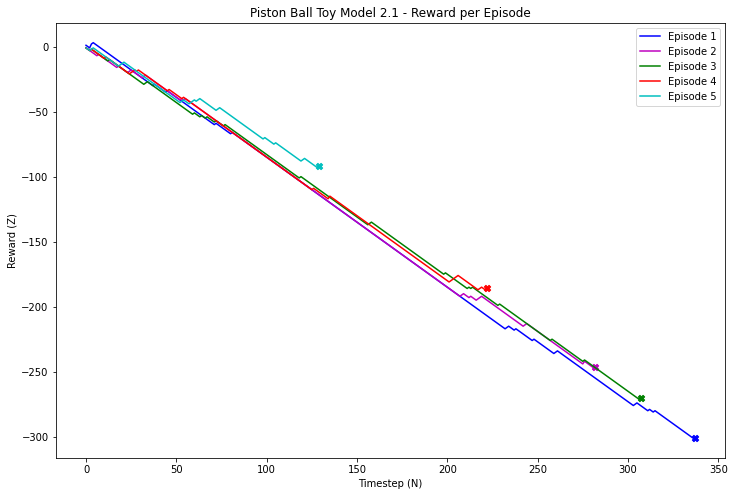

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
colours = ["b", "m", "g", "r", "c"]
 
for i in range(reward_lst.shape[0]):
  test = np.trim_zeros(reward_lst[i, :])
  plt.title("Piston Ball Toy Model 2.1 - Reward per Episode")
  ax.plot(test,color=colours[i])
  ax.scatter(len(test)-1, test[-1], marker='X',color=colours[i],s=40)
  ax.legend([f"Episode {i+1}" for i in range(reward_lst.shape[0])])
  ax.set_xlabel("Timestep (N)")
  ax.set_ylabel("Reward (Z)")

  print(f"Last Reward: {test[-1]} for Episode {i + 1}")